In [159]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [160]:
%aimport exv2.experiment_results 

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import glasbey

pd.set_option('display.max_columns', None)
sns.set_theme(rc={'figure.figsize':(12, 6)})

palette = glasbey.create_block_palette(
    [4, 3, 3, 2, 2],
    colorblind_safe=True,
    cvd_severity=90
)
sns.set_palette(palette)

In [161]:
NEW="data/2024-07-1*"
# KARL_LOCAL = "data/data/*"
exr = exv2.experiment_results.ExperimentResults(NEW, load_stats_history=True) # type: ignore
RUN_VARS = exv2.experiment_results.ExperimentResults.RUN_VARS # type: ignore

assert("loadgenerator" not in (list(exr.pods['name'].unique())))
assert("unkown" not in (list(exr.pods['instance'].unique())))


# Runtime Overhead

We try to calculate the ratio of how much resouces (CPU, MEM, Wattage, ...) are consumed that are not directly related to the actual computation. This is the runtime overhead.

In [162]:


node_model = {
    "sm-gpu": 32704316//1024,
    "ise-knode6": 32719632//1024,
    "ise-knode1": 32761604//1024,
}
memory_second_price = 0.003702 / 1024 # based on GCP N4 memory price per GB
vCPU_second_price = 0.032578 / 60 # based on GCP N4 vCPU price per hour
ws_price = 0.5 / 3_600_000 # based on germany mean kWh price

import numpy as np
def calculate_cost(row):
    # meory * cpu_seconds * price_per_memory_second + wattage * kwh_price
    return row['memory_usage'] * memory_second_price + np.ceil(row["cpu_usage"]) * vCPU_second_price  + (row["wattage_scaph"] * ws_price)

def calculate_memory_usage(row):
    return row['memory_usage'] * node_model[row['instance']]

# limit to exp_scale_fixed | fixed workload to make it a fair comparison
nodes = exr.nodes[(exr.nodes['instance'].isin(exr.pods['instance'].unique()))].copy()

# XXX we need to caclulate the memory usage for each node as we save the memory usage in percent
nodes["memory_usage"] = nodes.apply(calculate_memory_usage, axis=1)


# We calculate the cpu_seconds memory (MB) and wattage used per second for each node ... 

#"wattage_auxilary","temperture"
nodes = nodes.groupby(exr.RUN_VARS+['run_time','instance'])[["cpu_usage","memory_usage","wattage_kepler","wattage_scaph"]].sum()
nodes['cost'] = nodes.apply(calculate_cost, axis=1)

#pods = exr.pods[exr.pods["exp_workload"] == "exp_scale_fixed"]

pods = exr.pods.groupby(exr.RUN_VARS+['run_time','instance'])[["cpu_usage","memory_usage","wattage_kepler","wattage_scaph"]].sum()

# ... and calculate the runtime overhead by removing the total pod usage from the node usage
# we assume that the worklaod generator run on a separate node outside of the pod nodes
runtime_overhead_data = (nodes - pods)
runtime_overhead_data['cost'] = runtime_overhead_data.apply(calculate_cost, axis=1)
# runtime_overhead_data.groupby(["exp_workload","exp_branch"])[["cost"]].sum()

runtime_overhead_cost = 100*runtime_overhead_data.groupby(["exp_workload","exp_branch"])[["cost"]].sum()/nodes.groupby(["exp_workload","exp_branch"])[["cost"]].sum()
runtime_overhead_cost.reset_index(inplace=True)
runtime_overhead_cost

,exp_workload,exp_branch,cost
0,exp_scale_fixed,baseline_vanilla_full,35.636184
1,exp_scale_fixed,jvm_jvm-impoove_full,35.816762
2,exp_scale_fixed,monolith_feature_monolith_full,44.194220
3,exp_scale_fixed,norec_feature_norecommendations_full,45.714921
4,exp_scale_fixed,obs_feature_object-storage_full,32.014442
5,exp_scale_fixed,serverless_feature_serverless_full,52.044850
6,exp_scale_pausing,baseline_vanilla_full,40.984110
7,exp_scale_pausing,jvm_jvm-impoove_full,35.402936
8,exp_scale_pausing,monolith_feature_monolith_full,41.804237
9,exp_scale_pausing,norec_feature_norecommendations_full,55.070232


/var/folders/38/12xcnc5j0nz1sv3x5wj08c1w0000gn/T/ipykernel_27700/1219262529.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([lable_names[x.get_text()] for x in ax.get_yticklabels()])


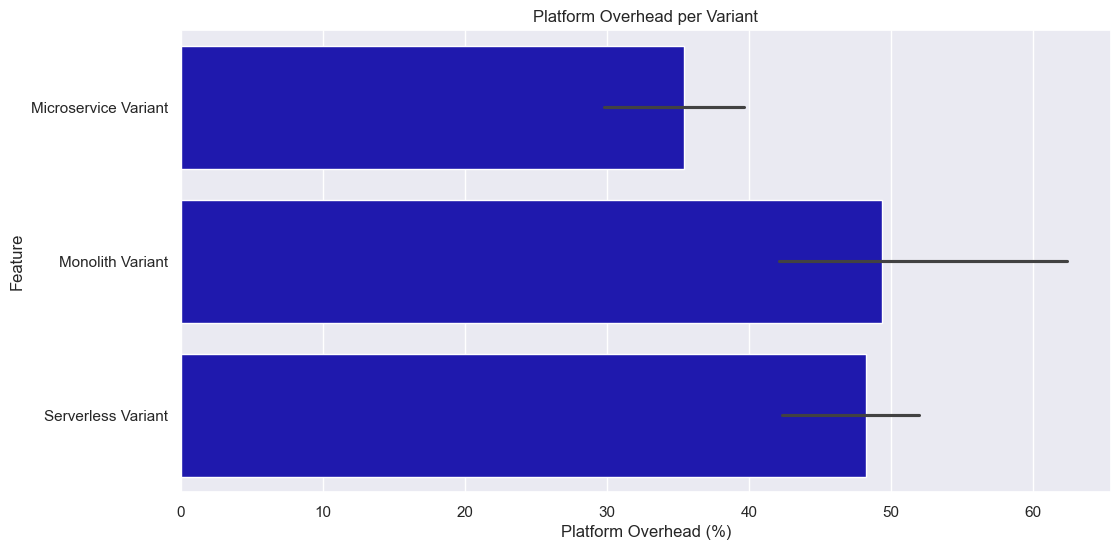

In [166]:
fig, ax = plt.subplots(figsize=(12, 6))
relevant_branches = ["baseline_vanilla_full","monolith_feature_monolith_full","serverless_feature_serverless_full"]
sns.barplot(data= runtime_overhead_cost[runtime_overhead_cost["exp_branch"].isin(relevant_branches)], y="exp_branch", x="cost",ax=ax)
ax.set_title("Platform Overhead per Variant")
ax.set_ylabel("Feature")
ax.set_xlabel("Platform Overhead (%)")

lable_names = {
    "baseline_vanilla_full": "Microservice Variant",
    'jvm_jvm-impoove_full': "Runtime Improvement",
    'monolith_feature_monolith_full': "Monolith Variant",
    'norec_feature_norecommendations_full' : "Service Reduction",
    'obs_feature_object-storage_full' : "Infrastructure Service Replacement",
    'serverless_feature_serverless_full' : "Serverless Variant",
}

ax.set_yticklabels([lable_names[x.get_text()] for x in ax.get_yticklabels()])
fig.savefig("figs/platform_overhead_deploymentes.pdf", bbox_inches='tight')

/var/folders/38/12xcnc5j0nz1sv3x5wj08c1w0000gn/T/ipykernel_27700/461204853.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([lable_names[x.get_text()] for x in ax.get_yticklabels()])


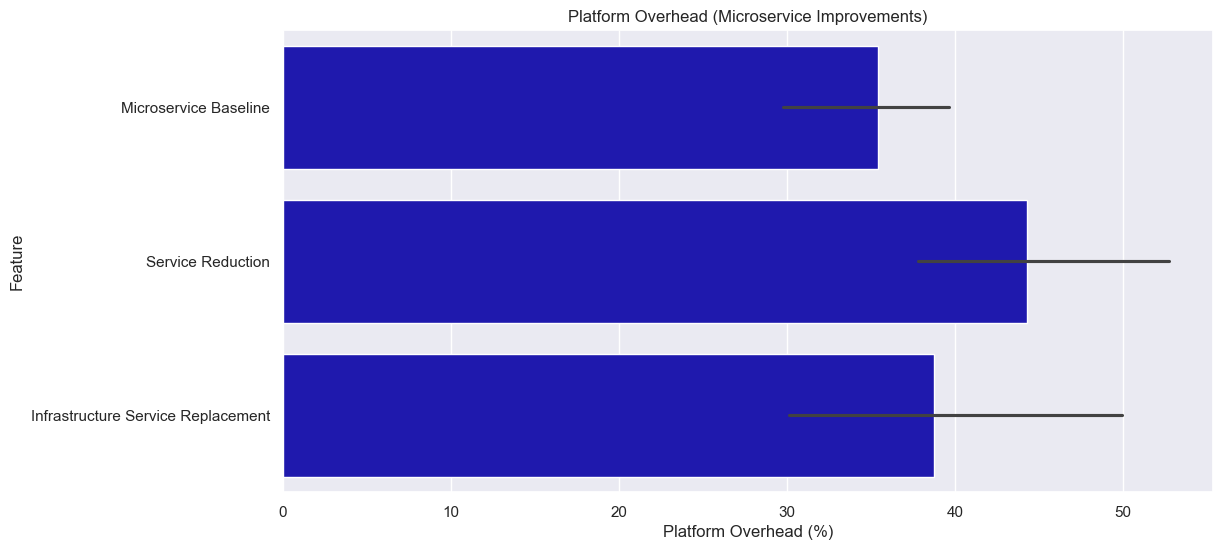

In [165]:
fig, ax = plt.subplots(figsize=(12, 6))
relevant_branches = ["baseline_vanilla_full","obs_feature_object-storage_full","norec_feature_norecommendations_full"]
sns.barplot(data= runtime_overhead_cost[runtime_overhead_cost["exp_branch"].isin(relevant_branches)], y="exp_branch", x="cost",ax=ax)
ax.set_title("Platform Overhead (Microservice Improvements)")
ax.set_ylabel("Feature")
ax.set_xlabel("Platform Overhead (%)")

lable_names = {
    "baseline_vanilla_full": "Microservice Baseline",
    'jvm_jvm-impoove_full': "Runtime Improvement",
    'monolith_feature_monolith_full': "Monolith Variant",
    'norec_feature_norecommendations_full' : "Service Reduction",
    'obs_feature_object-storage_full' : "Infrastructure Service Replacement",
    'serverless_feature_serverless_full' : "Serverless Variant",
}

ax.set_yticklabels([lable_names[x.get_text()] for x in ax.get_yticklabels()])
fig.savefig("figs/platform_overhead_ms_impo.pdf", bbox_inches='tight')